## Project: Wildfire Destructive Potential Index 

### Module 2: *Feature Engineering*

---
### Contents  
- 1. Construct WDFI (Wildfire Destructive Potential Index)
- 2. Independent Variables Analysis
- 3. Feature Engineering
- 4. Feature Selection and Correlation Analysis
---
### Notes
---
### Inputs
- `merged_weather_fire` cleaned weather data joined with fire damage dataset
- `palisades_weather.csv`, `dixie_weather.csv` seperate datasets for case studies
---
### Outputs 
- `X`,`pal_X`, `dixie_X`
- `Y`, `pal_y`,`dixie_y`
- `pal_details`,`dixie_details`
---
### User Defined Dependencies

In [1]:
import os
import sys

# Allow import of custom modules from the parent directory
sys.path.append(os.path.abspath(os.path.join('..')))

from src.plot_utils import grid_box
from src.plot_utils import grid_kde
from src.plot_utils import correlation_map
from src.plot_utils import build_index
from src.data_utils import create_2nd_degree_interactions
from src.data_utils import rank_interactions_by_correlation

---
### Third Party Dependencies

In [2]:
# Core data tools
import pandas as pd
import numpy as np

import os
import sys

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

# Modeling prep
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Set consistent plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

# Allow import of custom modules from the parent directory
sys.path.append(os.path.abspath(os.path.join('..')))

from src.plot_utils import grid_box
from src.plot_utils import grid_kde
from src.plot_utils import build_index
from src.data_utils import calculate_dryness_index

---

### Load Datasets

In [3]:
# Load cleaned main dataset
final = pd.read_csv("../data/processed/merged_weather_fire.csv", parse_dates=['Date'])
# housekeeping sort main file by station and reset index
final = final.sort_values(by='Stn Id').reset_index(drop=True)


# Load Palisades and Dixie Fire test data
palisades_weather = pd.read_csv("../data/processed/palisades_weather.csv", parse_dates=['Date'])
dixie_weather = pd.read_csv("../data/processed/dixie_weather.csv", parse_dates=['Date'])

---

## 1. Target Variable

### 1.1 Target - Wildfire Destructive Power index

Used `Structures damaged or destroyed` and `total fatalities` to construct a target to approximate the detructive power of a wildfire. Opted to leave `acres burned` out of this calculation due to the large variability of acreage burned to destruction caused. This will be incorporated later.

In [4]:
final['Struct'] = final['Dam.'] + final['Dest.']
final['Fatal'] =  final['Fire'] + final['Civil']

# list to calculate index
damage_measures = ['Struct', 'Fatal']

# save indexes of fire events by selecting any days with damage done
non_zero = final[(final[damage_measures] > 0).any(axis=1)].index

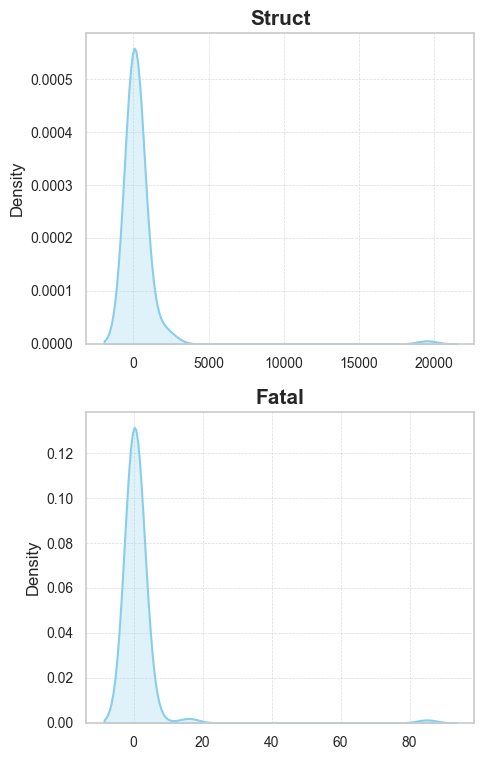

In [5]:
grid_kde(final.loc[non_zero, damage_measures])

Winsorize the damage variables to miminize the effects of extreme outliers

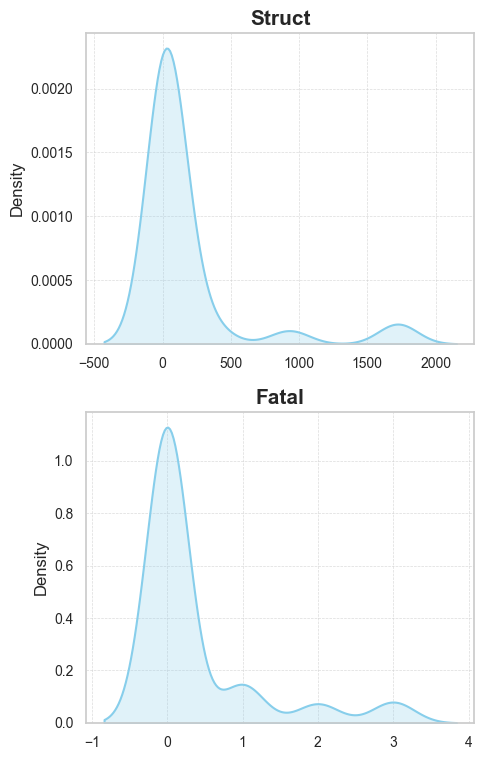

In [6]:
for col in damage_measures:
    upper_cap = final.loc[non_zero, damage_measures].quantile(0.95)
    final.loc[non_zero, damage_measures] = final.loc[non_zero, damage_measures].clip(upper=upper_cap,axis=1)
    
grid_kde(final.loc[non_zero, damage_measures])

Scale the data before construction of the index.

In [7]:
scaler = MinMaxScaler()
final.loc[non_zero, damage_measures] = scaler.fit_transform(final.loc[non_zero, damage_measures])

Wildfire Destructive Power Index Calculation: <br>

$WDPI = 1 * Structures + 10 * Fatalities$

In [8]:
final['WDFI'] = (
    1 * final['Struct'] +
    10 * final['Fatal']
)

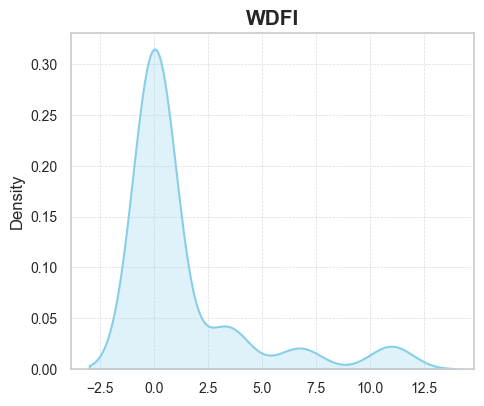

In [9]:
subset = final.loc[non_zero,:]
grid_kde(subset[['WDFI']])

### 1.2 Creating a Categorical Index for Fire Severity

The target variable is initially categorized into three classes based on **days burned** and **WDFI (Wildfire Danger Fire Index)** values:

- **Low**: Days with **no fire activity** (days burned = 0).

- **Moderate**: Days with **at least one day burned** and **WDFI below the mean** WDFI value across all fire days.

- **High**: Days with **at least one day burned** and **WDFI above the mean** WDFI value across all fire days.

This classification helps the model distinguish between no-fire days, moderately destructive fire days, and highly destructive fire days.

In [10]:
# Define conditions
cond_low = (final['Days'] == 0)
cond_mod = (final['Days'] > 0) & (final['WDFI'] < final.loc[non_zero,'WDFI'].mean())
cond_high = ~(cond_low | cond_mod)  # Everything else

# Define choices
choices = ['Low', 'Moderate', 'High']

# Apply conditions
final['Target'] = np.select(
    [cond_low, cond_mod, cond_high],
    choices,
    default='Unknown'  # Optional fallback
)


In [11]:
print('Initial distribution of classification by number of days: \n', final['Target'].value_counts())

Initial distribution of classification by number of days: 
 Target
Low         99115
Moderate      557
High           45
Name: count, dtype: int64


#### Note
Some fires caused minimal structural damage but burned a large amount of acres. Any fire **greater than 5000 acres** is reclassified as highly destructive.

subset = final[final['Total'] > 5000].index
final.loc[subset,['Target']] = 'High'

In [12]:
print('Final distribution of classification by number of days: \n', final['Target'].value_counts())

Final distribution of classification by number of days: 
 Target
Low         99115
Moderate      557
High           45
Name: count, dtype: int64


### 1.3 Spread Category Over Fire Duration

Spread the severity category across all days that a fire burned (not just the start date).

In [13]:
final['Days'].sum() - len(final[final['Days']>0])

np.float64(10292.0)

In [14]:
stations = final['Stn Id'].unique()
subset = final[final['Stn Id'] == stations[0]]

for station in stations:
    subset = final[final['Stn Id'] == station].index
    last = subset.max()
    
    for index in subset:
        days = int(final.loc[index,'Days'])
        
        for i in range(days):
            if ((index + i) != last):
                final.loc[index + i,'Target'] = final.loc[index,'Target']

**Validation:**

In [15]:
# find an index with a fire event
example_idx = final[final['Days'] > 2].index

# extract total days of fire
days = int(final.loc[example_idx[0], 'Days'])

# print following indexes to confirm change
target_val = final.loc[example_idx[0], 'Target']
print(final.loc[example_idx[0] : example_idx[0] + days, ['Target', 'Days']])

       Target   Days
476  Moderate  118.0
477  Moderate    0.0
478  Moderate    0.0
479  Moderate    0.0
480  Moderate    0.0
..        ...    ...
590  Moderate    0.0
591  Moderate    0.0
592  Moderate    0.0
593  Moderate    0.0
594  Moderate    1.0

[119 rows x 2 columns]


In [16]:
print('Final distribution of classification by number of days: \n', final['Target'].value_counts())

Final distribution of classification by number of days: 
 Target
Low         90572
Moderate     7801
High         1344
Name: count, dtype: int64


### 1.4 Visualize final distribution

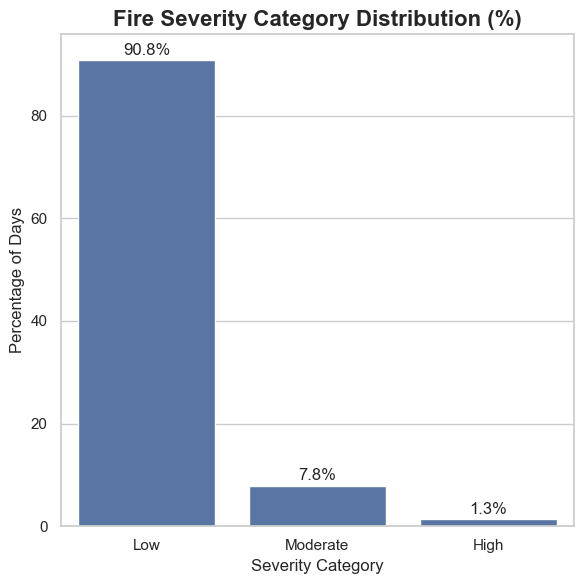

In [17]:
# Calculate percentage values
category_percent = (
    final['Target']
    .value_counts(normalize=True)
    .reindex(['Low', 'Moderate', 'High']) * 100
)

# Bar plot of percentages using default Seaborn colors
plt.figure(figsize=(6, 6))
sns.barplot(
    x=category_percent.index,
    y=category_percent.values
)

# Add percentage labels
for i, pct in enumerate(category_percent):
    plt.text(i, pct + 0.5, f"{pct:.1f}%", ha='center', va='bottom', fontsize=12)

plt.title('Fire Severity Category Distribution (%)', fontsize=16, weight='bold')
plt.xlabel('Severity Category')
plt.ylabel('Percentage of Days')
plt.ylim(0, category_percent.max() + 5)
plt.tight_layout()
plt.show()

## 2. Feature Exploration and Selection

This section visualizes key environmental variables to assess their relationships with wildfire severity categories. Based on the `Categorical Index`, we explore how different weather features interact and influence fire risk.

### 2.1 Seperate target and independent variables

In [18]:
# Copy details for use later in the project
final_details = final[['class', 'WDFI','Stn Id','Latitude','Longitude','Target',
                       'Stn Name','CIMIS Region','Date','County','_merge']]

# create a new dataframe with only independent variables and target index for analysis
filtered = final.drop(columns = ['Dest.','Dam.','Fire','Total','Civil','Days','Struct','Fatal',
                                 'class','WDFI','Stn Id','Latitude','Longitude',
                                 'Target','Stn Name','CIMIS Region','Date','OBJECTID','County','_merge'])

In [19]:
# convert categorical target to numerical for correlation analysis
custom_map = {'Low':0,'Moderate':1,'High':2}
filtered['Target Index'] = final['Target'].map(custom_map)

# Define a consistent order for categorical severity labels (used in plotting)
custom_order = ['Low', 'Moderate', 'High']

### Note  
To reduce dataset size and simplify analysis, the following steps were taken:  
- Dropped **Min** and **Max Air Temperature**, retained **Average Air Temperature**  
- Dropped **Min** and **Max Relative Humidity**, retained **Average Relative Humidity**

In [20]:
drop = ['Max Air Temp (F)','Min Air Temp (F)','Max Rel Hum (%)','Min Rel Hum (%)', 'Target Index']
drop

['Max Air Temp (F)',
 'Min Air Temp (F)',
 'Max Rel Hum (%)',
 'Min Rel Hum (%)',
 'Target Index']

### 4.2 DIrect Water Demand Indicators

- `ETo (in)` - Evapotranspiration is a measure of how much water is lost to the atmosphere
- `Sol Rad (Ly/day)` - A measure of sunlight the soil has recieved in a day
- `Avg Air Temp (F)`- Elevated air temperatures increase vegetation dryness and boost fire intensity  
- `Avg Wind Speed (mph)` - Stronger winds accelerate fire spread and push embers further, creating spot fires 
- `Avg Soil Temp (F)` - Warm soils suggest extended dry periods; contribute to desiccated fuel beds  
- `Wind Run (miles)` - Total wind movement over time; influences how far and fast fires can travel

In [21]:
water_demand = ['ETo (in)', 'Sol Rad (Ly/day)', 'Avg Air Temp (F)', 'Avg Wind Speed (mph)', 
                'Avg Soil Temp (F)','Wind Run (miles)', 'Target Index']

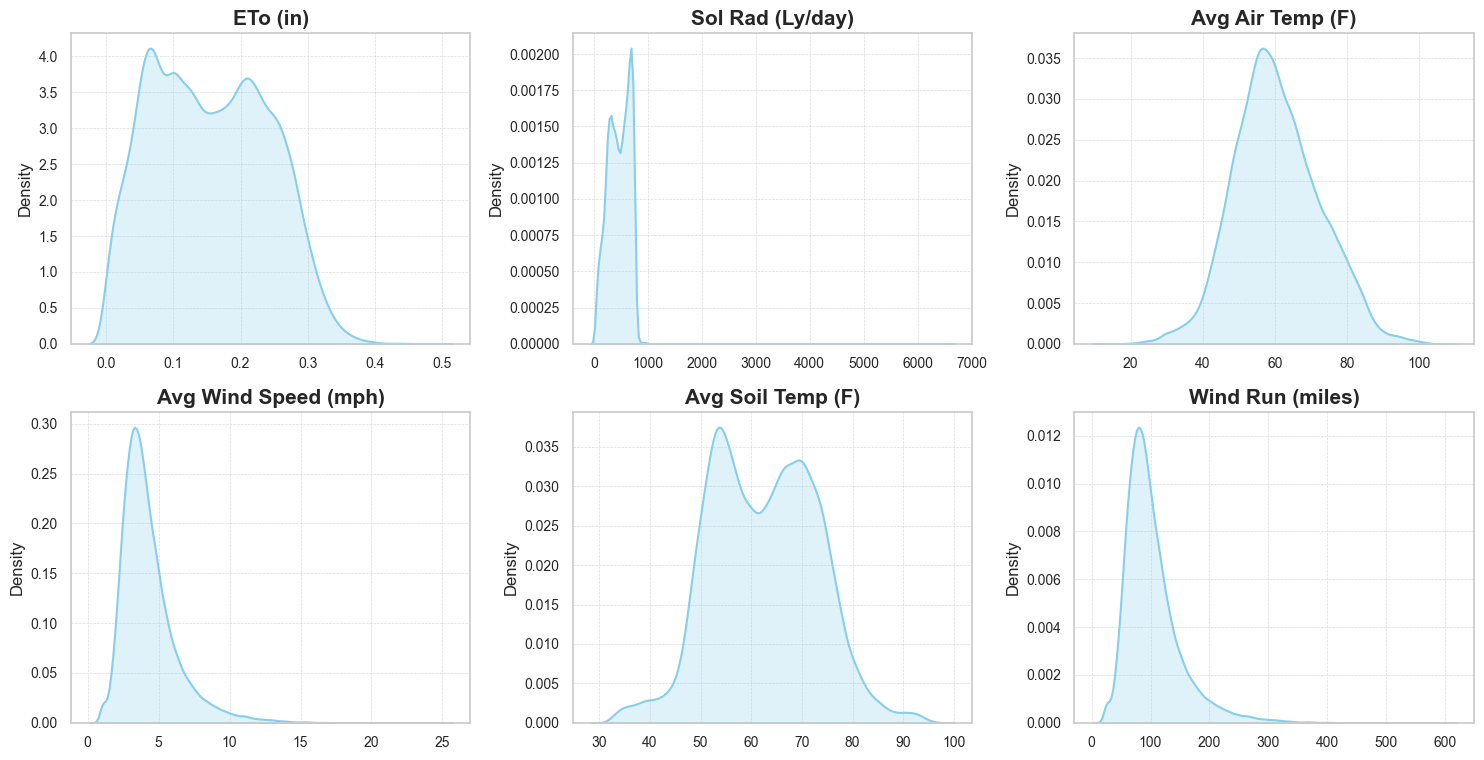

In [22]:
grid_kde(filtered[water_demand].drop(columns='Target Index'))

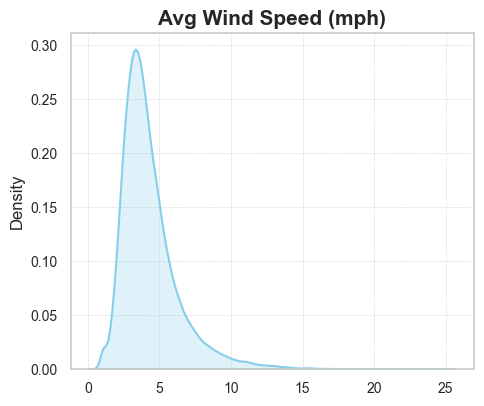

In [23]:
filtered['Avg Wind Speed (mph)'] = filtered['Avg Wind Speed (mph)'].clip(upper=400)

grid_kde(filtered[['Avg Wind Speed (mph)']])

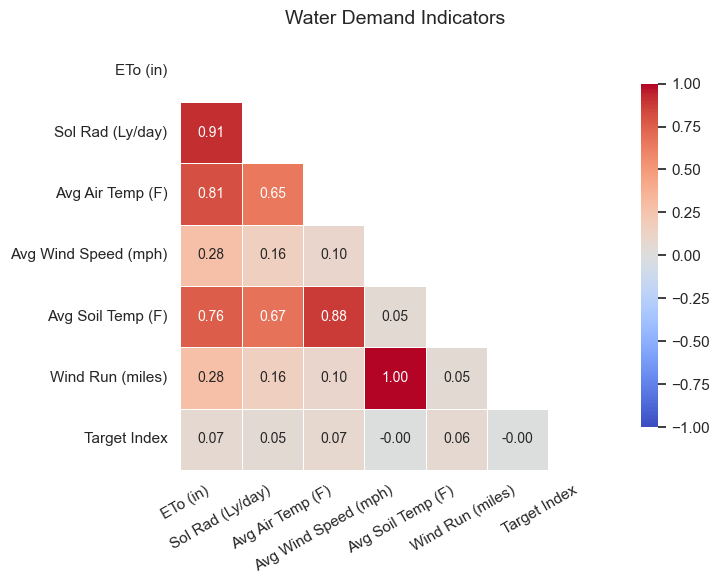

In [24]:
correlation_map(filtered[water_demand],'Water Demand Indicators')

#### Key Insights: Water Demand Variables

- **Evapotranspiration (ETo)** and **Solar Radiation** show a strong positive correlation, indicating shared influence from sunlight and temperature — both crucial in assessing vegetation moisture loss.
  
- **Dew Point** and **Vapor Pressure** are highly correlated, suggesting they provide overlapping information. These variables reflect atmospheric moisture content and may be redundant in modeling.

- Together, these indicators are effective in representing **vegetation dryness**, a critical factor in estimating wildfire ignition and spread potential.

- `ETO` and `Avg Vapor Pressure` are more correllated with target


#### Colinearity examination

<Axes: xlabel='ETo (in)', ylabel='Sol Rad (Ly/day)'>

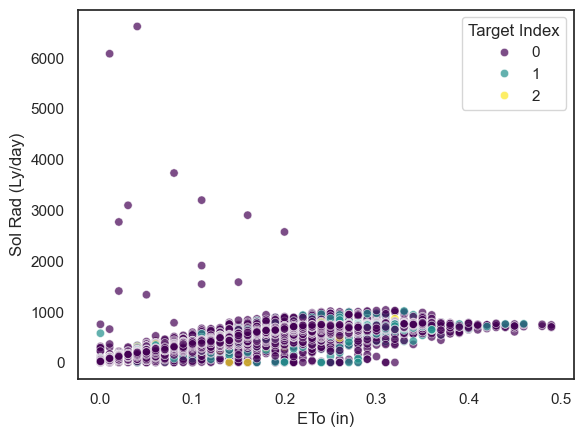

In [25]:
sns.scatterplot(
    x='ETo (in)', y='Sol Rad (Ly/day)', hue='Target Index', data=filtered, 
    hue_order=custom_order, palette='viridis', alpha=0.7
)

#### Water Demand Indicators - Key Findings

- **Evapotranspiration (ETo)** and **Solar Radiation** showed a **strong positive correlation**, indicating that days with high solar energy also tend to have greater evaporative demand. This aligns with meteorological understanding and highlights both as valuable indicators of fuel dryness.

<Axes: xlabel='Avg Wind Speed (mph)', ylabel='Wind Run (miles)'>

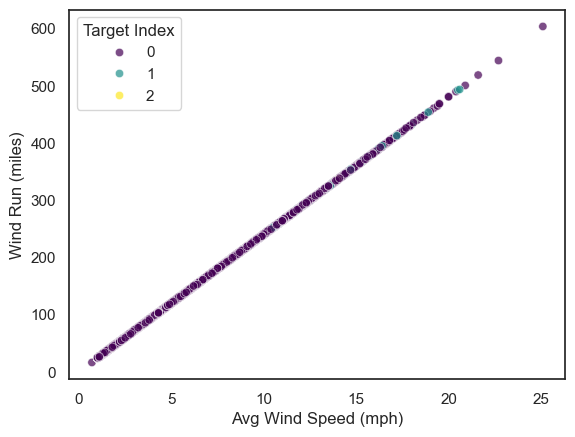

In [26]:
sns.scatterplot(
    x='Avg Wind Speed (mph)', y='Wind Run (miles)', hue='Target Index', data=filtered,
    hue_order=custom_order, palette='viridis', alpha=0.7
)

<Axes: xlabel='Avg Soil Temp (F)', ylabel='Avg Air Temp (F)'>

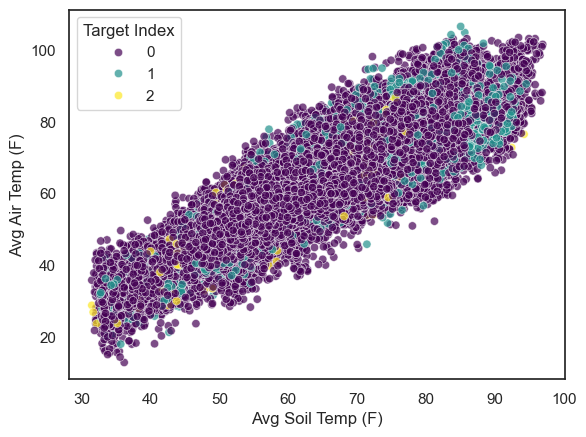

In [27]:
sns.scatterplot(
    x='Avg Soil Temp (F)', y='Avg Air Temp (F)', hue='Target Index', data=filtered,
    hue_order=custom_order, palette='viridis', alpha=0.7
)

In [28]:
drop.extend(['Wind Run (miles)'])
drop

['Max Air Temp (F)',
 'Min Air Temp (F)',
 'Max Rel Hum (%)',
 'Min Rel Hum (%)',
 'Target Index',
 'Wind Run (miles)']

### 4.3 Water Supply Indicators

- `Precip (in)` - Rainfall reduces wildfire risk by moistening vegetation and fuels; prolonged dryness increases flammability
- `Avg Rel Hum (%)` - Average relative humidity reflects how saturated the air is; lower values dry out fuels and promote ignition
- `Avg Vap Pres (mBars)` - Vapor pressure indicates moisture content in the air; lower pressure signals drier conditions favorable for fire spread  
- `Dew Point (F)` - The temperature at which air becomes saturated; lower dew points mean drier air, increasing fire potential 

In [29]:
water_supply = ['Precip (in)', 'Avg Rel Hum (%)', 'Avg Vap Pres (mBars)', 'Dew Point (F)', 'Target Index']

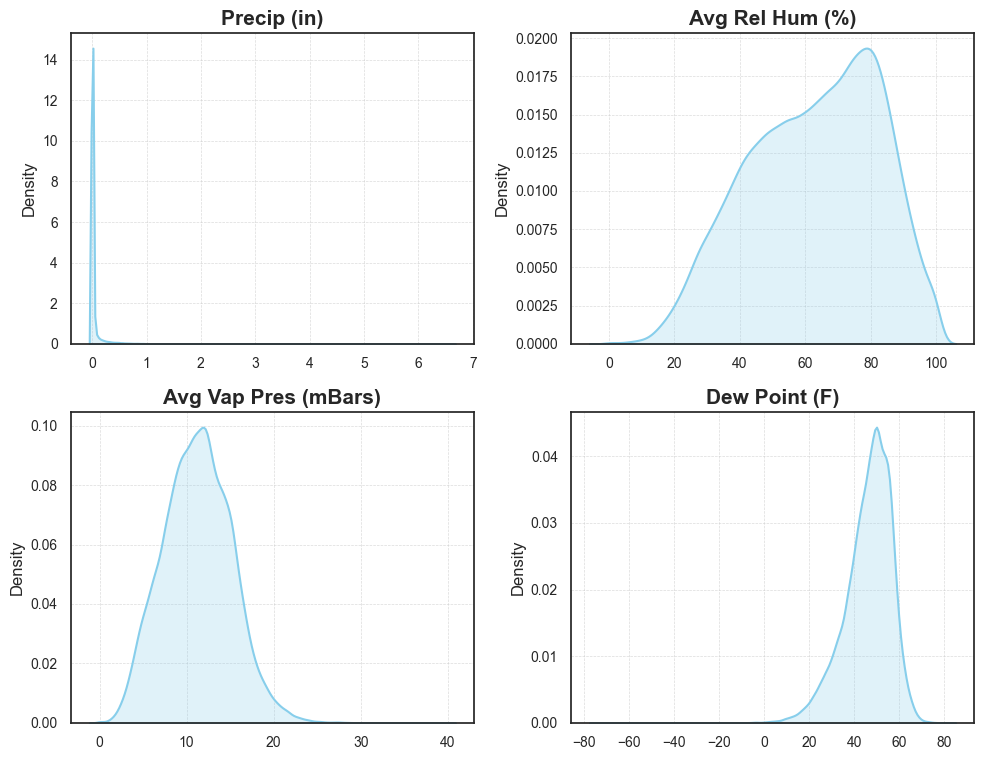

In [30]:
grid_kde(filtered[water_supply].drop(columns='Target Index'))

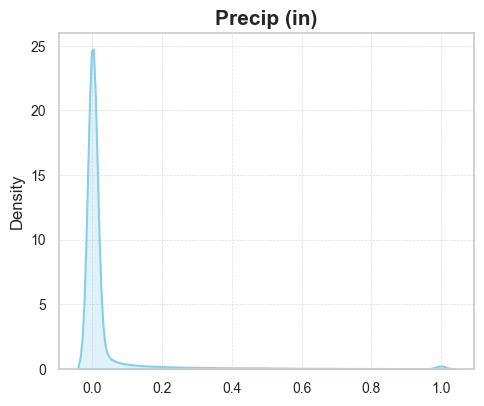

In [31]:
filtered['Precip (in)'] = filtered['Precip (in)'].clip(upper=1)

grid_kde(filtered[['Precip (in)']])

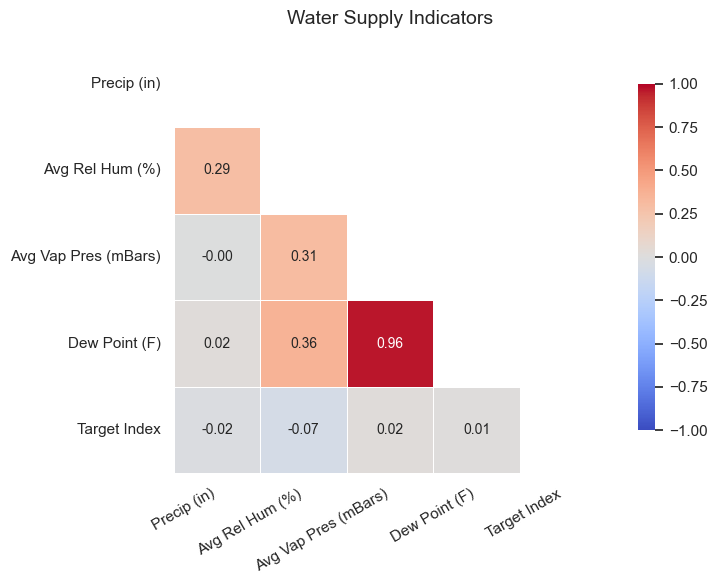

In [32]:
correlation_map(filtered[water_supply],'Water Supply Indicators')

#### Water Supply Indicators – Key Insights

- **Inverse Relationship with Fire Severity**  
  Both precipitation and relative humidity indicators are **negatively correlated** with the categorical fire risk index. This aligns with domain expectations—**drier and less humid conditions correspond to higher wildfire severity**.

<Axes: xlabel='Avg Vap Pres (mBars)', ylabel='Dew Point (F)'>

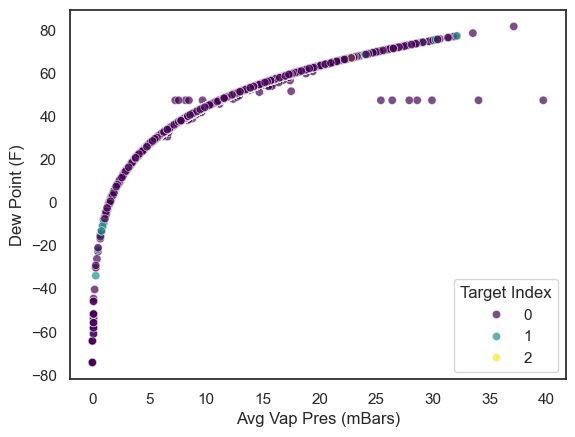

In [33]:
sns.scatterplot(
    x='Avg Vap Pres (mBars)', y='Dew Point (F)', hue='Target Index', data=filtered, 
    hue_order=custom_order, palette='viridis', alpha=0.7
)

Drop `Dew Point (F)` due to **colinearity** with `Avg Vap Pres (mBars)` and less correlation with the target index

In [34]:
drop.extend(['Dew Point (F)'])
drop

['Max Air Temp (F)',
 'Min Air Temp (F)',
 'Max Rel Hum (%)',
 'Min Rel Hum (%)',
 'Target Index',
 'Wind Run (miles)',
 'Dew Point (F)']

## 3. Feature Engineering

This section constructs a wildfire Severity Index from various damage metrics, and categorizes fire severity for modeling.

### 3.1 Dryness Indicator

PET_proxy = a * T_mean + b * Wind + c * SolarRadiation - d * Humidity

In [35]:
final['Dryness'] = calculate_dryness_index(final).astype(float)
palisades_weather['Dryness'] = calculate_dryness_index(palisades_weather)
dixie_weather['Dryness'] = calculate_dryness_index(dixie_weather)

#final['Dryness'] = pd.qcut(final['Dryness'], q=3, labels=[0, 1, 2])

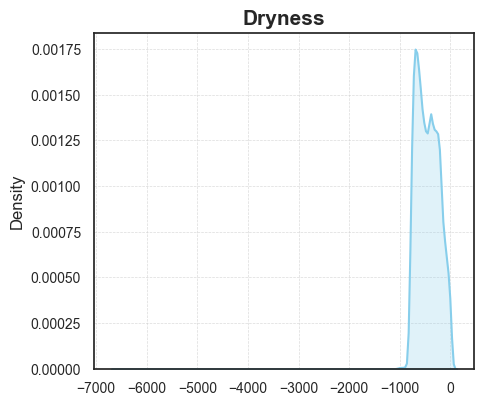

In [36]:
grid_kde(final[['Dryness']])

### 3.2 Add Lagged Weather Variables

We calculate 7-day rolling averages for select weather variables to capture recent trends that may influence fire severity.

In [37]:
# Sort data by County and Date to prepare for rolling average
final = final.sort_values(by=['County', 'Date'])
pal_filtered = palisades_weather.sort_values(by=['County', 'Date'])
dixie_filtered = dixie_weather.sort_values(by=['County', 'Date'])

# Define columns for 7-day rolling average
avg_columns = [
    'Avg Air Temp (F)', 
    'Precip (in)',
    'Avg Rel Hum (%)', 
    'Avg Wind Speed (mph)'
]

# Apply rolling mean by County
for col in avg_columns:
    final[f'{col} 7 Day Avg'] = final.groupby('County')[col].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
    pal_filtered[f'{col} 7 Day Avg'] = pal_filtered.groupby('County')[col].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
    dixie_filtered[f'{col} 7 Day Avg'] = dixie_filtered.groupby('County')[col].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)

## 4.4 Feature Interaction Analysis

In [38]:
# ensure case study data is clean, drop any NA dates
pal_filtered = pal_filtered.dropna()
dixie_filtered = dixie_filtered.dropna()

In [39]:
# Store identifying metadata for later use (not used in modeling)
case_details = ['Date', 'Stn Name', 'County', 'CIMIS Region','Latitude','Longitude']
pal_details = pal_filtered[case_details]
dixie_details = dixie_filtered[case_details]

Create final dataframe of variables by dropping variables analyzed earlier.

In [40]:
y = filtered['Target Index']
X = filtered.drop(columns = drop)
pal_X = pal_filtered[X.columns]
dixie_X = dixie_filtered[X.columns]

Scale all datasets and save back to dataframe format

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scales and returns a NumPy array
pal_X_scaled = scaler.fit_transform(pal_X)
dixie_X_scaled = scaler.fit_transform(dixie_X)

In [42]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
pal_X_scaled = pd.DataFrame(pal_X_scaled, columns=pal_X.columns, index=pal_X.index)
dixie_X_scaled = pd.DataFrame(dixie_X_scaled, columns=dixie_X.columns, index=dixie_X.index)

For all independent variables create a new dataframe containing every possible interaction of 2nd degree

In [43]:
inter_X = create_2nd_degree_interactions(X_scaled)
inter_pal_X = create_2nd_degree_interactions(pal_X_scaled)
inter_dixie_X = create_2nd_degree_interactions(dixie_X_scaled)

Combine interaction terms with single variables for correlation analysis

In [44]:
inter_X_combined = pd.concat([X_scaled, inter_X], axis=1)
inter_pal_X_combined = pd.concat([pal_X_scaled, inter_pal_X], axis=1)
inter_dixie_X_combined = pd.concat([dixie_X_scaled, inter_dixie_X], axis=1)

### Interaction Correlation analysis

In [45]:
correlation_results = rank_interactions_by_correlation(inter_X_combined, y)
keep = correlation_results.head(20)['Feature'].tolist()

In [46]:
correlation_results.head(20)

,Feature,Correlation
0,Mean Income,-0.141273
1,Total Population x Mean Income,0.125068
2,Elevation,0.087176
3,Avg Air Temp (F),0.071408
4,ETo (in),0.069727
5,Avg Rel Hum (%),-0.068998
6,Avg Soil Temp (F),0.062602
7,Size (square miles),0.058929
8,Total Population x density,0.054573
9,Total Population x Size (square miles),-0.053747


Keep top 20 results

In [47]:
X = inter_X_combined[keep]
pal_X = inter_pal_X_combined[keep]
dixie_X = inter_dixie_X_combined[keep]

## 5. Scale Data

In [48]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale training and prediction datasets
scaled_X = scaler.fit_transform(X)
scaled_pal_X = scaler.fit_transform(pal_X)
scaled_dixie_X = scaler.fit_transform(dixie_X)

# Reconstruct scaled data into DataFrames
X = pd.DataFrame(scaled_X, columns=X.columns)
pal_X = pd.DataFrame(scaled_pal_X, columns=pal_X.columns)
dixie_X = pd.DataFrame(scaled_dixie_X, columns=pal_X.columns)

## Export Feature Data

In [49]:
X.to_csv('../data/processed/X.csv', index=False)
pal_X.to_csv('../data/processed/pal_X.csv', index=False)
dixie_X.to_csv('../data/processed/dixie_X.csv', index=False)
y.to_csv('../data/processed/y.csv', index=False)
pal_details.to_csv("../data/processed/pal_details.csv", index=False)
dixie_details.to_csv("../data/processed/dixie_details.csv", index=False)
print("All datasets saved successfully to ../data/processed/")

All datasets saved successfully to ../data/processed/
